# This study was carried out by İshak Kutlu within the scope of the Central Bank of the Republic of Türkiye specialization qualification thesis titled "Forecasting the Banknote Demand of the Economy with Artificial Intelligence Technologies and Time Series Analysis: A Comparison of Turkey-Wide and Eskişehir Branch Rediscount Region".
# You can review the vocational qualification thesis published in 2023 from the link below.

https://www.tcmb.gov.tr/wps/wcm/connect/TR/TCMB+TR/Main+Menu/Yayinlar/Calismalar/Uzmanlik+Tezleri/

In [44]:
!pip install pmdarima
#!pip install inflect
!pip install inflect==5.3.0



'''

!pip install pyramid-arima
!pip install utils
!pip install autopip
!pip install scikit-learn
!pip install base6
!pip install arch
!pip install openpyxl
!pip install tabulate

!pip install scikit-learn
!pip install SCALECAST
!pip install stldecompose

#!pip uninstall -y inflect==6.0.1

'''

'\n\n!pip install pyramid-arima\n!pip install utils\n!pip install autopip\n!pip install scikit-learn\n!pip install base6\n!pip install arch\n!pip install openpyxl\n!pip install tabulate\n\n!pip install scikit-learn\n!pip install SCALECAST\n!pip install stldecompose\n\n#!pip uninstall -y inflect==6.0.1\n\n'

In [45]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from tabulate import tabulate #for creating a table
import inflect #for converting writing numbers
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_predict

from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
import statistics
import datetime
import warnings
warnings.filterwarnings("ignore")

from matplotlib.collections import PolyCollection, LineCollection

In [46]:
T200 = "T200"
T100 = "T100"
T50 = "T50"
T20 = "T20"
T10 = "T10"
T5 = "T5"
T_Date = "T_Date"
denomination_name_list = [T200, T100, T50, T20, T10, T5]

#read by default 1st sheet of an excel file
#df = pd.read_excel('Tr_Data_2009.xlsx')
#df = pd.read_excel('Tr_Data_2009.xlsx', names= [T_Date, "T200", "T100", "T50", "T20", "T10", "T5"] , header=0) #FOR RUNNING IN COLAB
df = pd.read_excel('../input/esk-data-2009/Esk_Data_2009.xlsx', names= [T_Date, "T200", "T100", "T50", "T20", "T10", "T5"] , header=0) #FOR RUNNING IN KAGGLE



df = df[:168] 


#convert package: 1 package consists of 1000 banknotes.
dfdate = df[[T_Date]]
df=df.drop([T_Date], axis=1)
df=round(df.div(1000),0)
df = pd.concat([dfdate, df], axis=1)

#convert series to float
df[T200] = df[T200].astype(float)
df[T100] = df[T100].astype(float)
df[T50] = df[T50].astype(float)
df[T20] = df[T20].astype(float)
df[T10] = df[T10].astype(float)
df[T5] = df[T5].astype(float)

#convert series to date
#df[T_Date] = pd.to_datetime(df[T_Date])

df200=df[T200].to_frame()
df100=df[T100].to_frame()
df50=df[T50].to_frame()
df20=df[T20].to_frame()
df10=df[T10].to_frame()
df5=df[T5].to_frame()

df_list = [df200,df100,df50,df20,df10,df5]

#print(df.head())
#print(df.tail())
#print(df.iloc[0:10])
print(df.info())
#df=df.div(1000)
#df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   T_Date  168 non-null    datetime64[ns]
 1   T200    168 non-null    float64       
 2   T100    168 non-null    float64       
 3   T50     168 non-null    float64       
 4   T20     168 non-null    float64       
 5   T10     168 non-null    float64       
 6   T5      168 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 9.3 KB
None


In [47]:
#seperate training and testing data
#training_data, testing_data = train_test_split(df, test_size=0.3, shuffle=False)

dfdate = df[[T_Date]]

training_data = df[:156]
testing_data = df[156:]


#split series by denomination for training data
df200_train = training_data[[T200]]
df100_train = training_data[[T100]]
df50_train = training_data[[T50]]
df20_train = training_data[[T20]]
df10_train = training_data[[T10]]
df5_train = training_data[[T5]]
dfdate_train = training_data[[T_Date]]

df_train_list = [df200_train, df100_train, df50_train, 
                 df20_train, df10_train, df5_train]

#split series by denomination for testing data
df200_test = testing_data[[T200]]
df100_test = testing_data[[T100]]
df50_test = testing_data[[T50]]
df20_test = testing_data[[T20]]
df10_test = testing_data[[T10]]
df5_test = testing_data[[T5]]
dfdate_test = testing_data[[T_Date]]

df_test_list = [df200_test, df100_test, df50_test, 
              df20_test, df10_test, df5_test]
    
#convert df to array for training data
arr200_train = df200_train.to_numpy()
arr100_train = df100_train.to_numpy()
arr50_train = df50_train.to_numpy()
arr20_train = df20_train.to_numpy()
arr10_train = df10_train.to_numpy()
arr5_train = df5_train.to_numpy()
arrdate_train = dfdate_train.to_numpy()

arr_train_list = [arr200_train, arr100_train, arr50_train, 
                arr20_train, arr10_train, arr5_train]

#convert df to array for testing data
arr200_test = df200_test.to_numpy()
arr100_test = df100_test.to_numpy()
arr50_test = df50_test.to_numpy()
arr20_test = df20_test.to_numpy()
arr10_test = df10_test.to_numpy()
arr5_test = df5_test.to_numpy()
arrdate_test = dfdate_test.to_numpy()

arr_test_list = [arr200_test, arr100_test, arr50_test, 
                arr20_test, arr10_test, arr5_test]


In [48]:
#training_data


In [49]:
#testing_data

In [50]:
def preprocess_data(series, date):
    series = pd.concat([date, series], axis=1)
    series.timestamp = pd.to_datetime(series.T_Date , format = '%Y-%m')
    series.index = series.timestamp
    series.drop('T_Date',axis = 1, inplace = True)
    return series

def date_and_denomination():
    global df200_train_date
    global df100_train_date
    global df50_train_date
    global df20_train_date
    global df10_train_date
    global df5_train_date
    global df_train_list_date

    global df200_test_date
    global df100_test_date
    global df50_test_date
    global df20_test_date
    global df10_test_date
    global df5_test_date
    global df_test_list_date

    global df200_date
    global df100_date
    global df50_date
    global df20_date
    global df10_date
    global df5_date
    global df_list_date
    
    
    df200_train_date = preprocess_data(df200_train, dfdate_train)
    df100_train_date = preprocess_data(df100_train, dfdate_train)
    df50_train_date = preprocess_data(df50_train, dfdate_train)
    df20_train_date = preprocess_data(df20_train, dfdate_train)
    df10_train_date = preprocess_data(df10_train, dfdate_train)
    df5_train_date = preprocess_data(df5_train, dfdate_train)

    df_train_list_date = [df200_train_date, df100_train_date, df50_train_date, 
                     df20_train_date, df10_train_date, df5_train_date]

    df200_test_date = preprocess_data(df200_test, dfdate_test)
    df100_test_date = preprocess_data(df100_test, dfdate_test)
    df50_test_date = preprocess_data(df50_test, dfdate_test)
    df20_test_date = preprocess_data(df20_test, dfdate_test)
    df10_test_date = preprocess_data(df10_test, dfdate_test)
    df5_test_date = preprocess_data(df5_test, dfdate_test)
    
    #print(df5_train_date)
    df_test_list_date = [df200_test_date, df100_test_date, df50_test_date, 
                     df20_test_date, df10_test_date, df5_test_date]
    
    df200_date = preprocess_data(df200, dfdate)
    df100_date = preprocess_data(df100, dfdate)
    df50_date = preprocess_data(df50, dfdate)
    df20_date = preprocess_data(df20, dfdate)
    df10_date = preprocess_data(df10, dfdate)
    df5_date = preprocess_data(df5, dfdate)
    
    df_list_date = [df200_date,df100_date,df50_date,df20_date,df10_date,df5_date]
    
date_and_denomination()

#print(df100_train_date)
#print(df100_test_date)

'''
vertical_concat = pd.concat([dfdate_train, df200_train], axis=1)
print(vertical_concat)
'''


'\nvertical_concat = pd.concat([dfdate_train, df200_train], axis=1)\nprint(vertical_concat)\n'

In [51]:
def graph_color():
    global my_red
    global my_purple
    global my_turkois
    global my_blue
    global my_dark_blue
    global my_orange
    global my_gray
    global my_light_blue
    
    my_red=(204/235, 80/235, 85/235)
    my_purple=(123/235, 85/235, 118/235)
    my_turkois=(26/235, 168/235, 212/235)
    my_blue=(51/235, 94/235, 163/235)
    my_dark_blue=(0/235, 23/235, 58/235)
    my_orange=(221/235, 151/235, 47/235)
    my_gray=(172/235, 163/235, 150/235)
    my_light_blue=(186/235, 200/235, 220/235)
    
def plot_original_series(data, x_axis, y_axis): 
    #axes[x_axis, y_axis].data[data.columns.values[0]].plot()
    x = data.index
    y = data[data.columns.values[0]]
    axes[x_axis, y_axis].plot(x, y, color=my_gray)
    
    axes[x_axis, y_axis].set_title(data.columns.values[0],  y=1.1)#, fontsize=11)
    #axes[x_axis, y_axis].yaxis.tick_right()
    plt.sca(axes[x_axis, y_axis])
    plt.xlabel('Dönem')
    plt.ylabel('Paket Sayısı')
    #plt.xticks(rotation = 90)

def draw_original_series(df_data_list): 
    graph_color()
    x_axis=0;y_axis=0
    plt.subplots_adjust(hspace=0.5, wspace = 0.3)
    #plt.rcParams['font.size'] = 9
    fig.suptitle("Original Series", fontsize=13, y=1.0)
    #fig.tight_layout()
    for data in df_data_list:
        plot_original_series(data, x_axis, y_axis)
        if y_axis<2:
            y_axis+=1
        else:
            x_axis+=1
            y_axis=0
    plt.show()
    x_axis=0
    y_axis=0

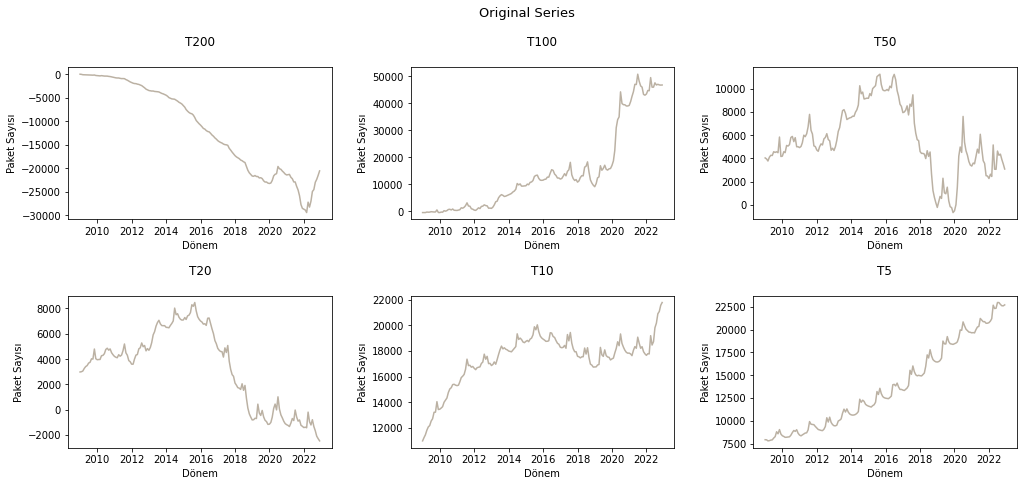

In [52]:

fig, axes = plt.subplots(2, 3, sharex=False, figsize=(17, 7))
#draw_original_series(df_list)
draw_original_series(df_list_date)


In [53]:
#send to only df for taking 1st diff of variable each time
def first_diff(diff_df):
    col_name = diff_df.columns.values[0]
    diff_df[diff_df.columns.values[0]] = diff_df[diff_df.columns.values[0]] - diff_df[diff_df.columns.values[0]].shift(1) #first different
    #diff_df = diff_df[diff_df.columns.values[0]].dropna()
    diff_df=diff_df.fillna(diff_df.iloc[0:5, 0:1].mean()) #write mean of next five stationary values instead of missing values
    diff_df = pd.DataFrame(diff_df, columns=[col_name])
    return diff_df
    #print(log_diff_np.head())

In [54]:
#If the series are not stationary, then gradually take 1st difference of log variable 
#in order to make time series stationary until the series are stationary.
#apply the ADF test to the series

date_and_denomination()

table_rows_list=[["(0) ADF Statistic"], 
                    ["(0) p-value"],
                    ["(0) Stat./Non-Stat."],
                    ["(1) ADF Statistic"],
                    ["(1) p-value"],
                    ["(1) Stat./Non-Stat."],
                    ["(2) ADF Statistic"],
                    ["(2) p-value"],
                    ["(2) Stat./Non-Stat."],
                    ["(3) ADF Statistic"],
                    ["(3) p-value"],
                    ["(3) Stat./Non-Stat."]]
stationary_list_ADF = []
for x in df_train_list_date:
    stationary_series = x
    diff_degree=0
    order_degree=0
    out_index=0
    for y in range(4):
        result = adfuller(stationary_series.values, 
                          maxlag=None, 
                          regression='n', #{“c”,”ct”,”ctt”,”n”}
                          autolag='AIC', 
                          store=False, 
                          regresults=False) 
        #print(result)
        table_rows_list[diff_degree].append(result[0]) #adf
        diff_degree+=1
        table_rows_list[diff_degree].append(result[1]) #p value
        if result[1] < 0.05:
            diff_degree+=1
            table_rows_list[diff_degree].append(inflect.engine().number_to_words(order_degree).capitalize() + "-Order Stationary")
            stationary_list_ADF.append(stationary_series)
            if diff_degree == len(table_rows_list)-1:
                break
            elif diff_degree<len(table_rows_list)-1:
                for m in range(diff_degree,len(table_rows_list)-1):
                    diff_degree+=1
                    table_rows_list[diff_degree].append("")
                    if diff_degree == len(table_rows_list)-1:
                        out_index=1
                if out_index==1:
                    break
        else:
            #print("Non-stationary")
            diff_degree+=1
            table_rows_list[diff_degree].append("Non-Stationary")
            stationary_series = first_diff(stationary_series) #difference based on absolute value
            order_degree+=1
            if diff_degree==len(table_rows_list)-1:
                break
        diff_degree+=1
        
#create table
table_columns_list = ["(Degree) Statistics", T200, T100, T50, T20, T10, T5]
print (tabulate(table_rows_list, headers=table_columns_list))

date_and_denomination()

'''
print("\n___________")
print(stationary_list_ADF[1].info())
print("\n___________")

date_and_denomination()
print(df100_train_date.info())
print(df100_train_date)
'''


(Degree) Statistics    T200                    T100                  T50                     T20                    T10                   T5
---------------------  ----------------------  --------------------  ----------------------  ---------------------  --------------------  ----------------------
(0) ADF Statistic      2.0865409175022163      -0.4031269005285582   -1.08161768648732       -1.5002940721752318    -0.17561536409122558  2.819685077259863
(0) p-value            0.9923976637507214      0.5354614918319067    0.2525747262305752      0.1251709501319203     0.622883182794356     0.9995209169038701
(0) Stat./Non-Stat.    Non-Stationary          Non-Stationary        Non-Stationary          Non-Stationary         Non-Stationary        Non-Stationary
(1) ADF Statistic      -1.1961204032147643     -1.957285567136696    -1.8847565932344468     -1.4701357950190175    -2.2461572958491325   -0.4759807840389915
(1) p-value            0.21195226199706502     0.048072506030329754  0.056

'\nprint("\n___________")\nprint(stationary_list_ADF[1].info())\nprint("\n___________")\n\ndate_and_denomination()\nprint(df100_train_date.info())\nprint(df100_train_date)\n'

In [55]:
#If the series are not stationary, then gradually take 1st difference of absolute variable 
#in order to make time series stationary until the series are stationary.
#apply the KPSS test to the series

table_rows_list=[["(0) KPSS Statistic"], 
                    ["(0) p-value"],
                    ["(0) Stat./Non-Stat."],
                    ["(1) KPSS Statistic"],
                    ["(1) p-value"],
                    ["(1) Stat./Non-Stat."],
                    ["(2) KPSS Statistic"],
                    ["(2) p-value"],
                    ["(2) Stat./Non-Stat."],
                    ["(3) KPSS Statistic"],
                    ["(3) p-value"],
                    ["(3) Stat./Non-Stat."]]
stationary_list_KPSS = []
for x in df_train_list_date:
    stationary_series = x
    diff_degree=0
    order_degree=0
    out_index=0
    for y in range(4):
        result = kpss(stationary_series.values, 
                      regression='c', #{“c”, “ct”}
                      nlags='auto', 
                      store=False) 
        #print(result)
        table_rows_list[diff_degree].append(result[0]) #kpss
        diff_degree+=1
        table_rows_list[diff_degree].append(result[1]) #p value
        if result[1] > 0.05:
            diff_degree+=1
            table_rows_list[diff_degree].append(inflect.engine().number_to_words(order_degree).capitalize() + "-Order Stationary")
            stationary_list_KPSS.append(stationary_series)
            if diff_degree == len(table_rows_list)-1:
                break
            elif diff_degree<len(table_rows_list)-1:
                for m in range(diff_degree,len(table_rows_list)-1):
                    diff_degree+=1
                    table_rows_list[diff_degree].append("")
                    if diff_degree == len(table_rows_list)-1:
                        out_index=1
                if out_index==1:
                    break
        else:
            #print("Non-stationary")
            diff_degree+=1
            table_rows_list[diff_degree].append("Non-Stationary")
            stationary_series = first_diff(stationary_series)
            order_degree+=1
            if diff_degree==len(table_rows_list)-1:
                break
        diff_degree+=1
        
#create table
table_columns_list = ["(Degree) Statistics", T200, T100, T50, T20, T10, T5]
print (tabulate(table_rows_list, headers=table_columns_list))

date_and_denomination()

(Degree) Statistics    T200                  T100                  T50                    T20                   T10                   T5
---------------------  --------------------  --------------------  ---------------------  --------------------  --------------------  --------------------
(0) KPSS Statistic     1.8070580570553696    1.404496178481976     0.42337037358116225    0.9456275742100754    1.02628937176241      1.7837228616577225
(0) p-value            0.01                  0.01                  0.0670817355253611     0.01                  0.01                  0.01
(0) Stat./Non-Stat.    Non-Stationary        Non-Stationary        Zero-Order Stationary  Non-Stationary        Non-Stationary        Non-Stationary
(1) KPSS Statistic     0.38585759275018033   0.2265035132499463                           0.47896411373056824   0.6005757024111837    0.08359165524215202
(1) p-value            0.08325103760768089   0.1                                          0.046404478889511665  0

In [56]:
#series = pd.concat([date, series], axis=1)
one_order_stationary=pd.DataFrame()
for one_order in stationary_list_KPSS: 
    #print(one_order)
    one_order_stationary = pd.concat([one_order_stationary, one_order], axis=1)

one_order_200=stationary_list_KPSS[0]
one_order_100=stationary_list_KPSS[1]
one_order_50=stationary_list_KPSS[2]
one_order_20=stationary_list_KPSS[3]
one_order_10=stationary_list_KPSS[4]
one_order_5=stationary_list_KPSS[5]

#one_order_stationary
#one_order_5
corr=one_order_stationary.corr(method='pearson') #correlation matrix of stationary training set for c parameter (KPSS)
corr

,T200,T100,T50,T20,T10,T5
T200,1.000000,0.728818,0.007255,0.310554,0.262988,0.319605
T100,0.728818,1.000000,0.042645,0.573921,0.517333,0.606585
T50,0.007255,0.042645,1.000000,0.012428,0.030087,0.135070
T20,0.310554,0.573921,0.012428,1.000000,0.952461,0.573009
T10,0.262988,0.517333,0.030087,0.952461,1.000000,0.639899
T5,0.319605,0.606585,0.135070,0.573009,0.639899,1.000000


In [57]:
#series = pd.concat([date, series], axis=1)
one_order_stationary=pd.DataFrame()
for one_order in stationary_list_ADF: 
    #print(one_order)
    one_order_stationary = pd.concat([one_order_stationary, one_order], axis=1)

one_order_200=stationary_list_ADF[0]
one_order_100=stationary_list_ADF[1]
one_order_50=stationary_list_ADF[2]
one_order_20=stationary_list_ADF[3]
one_order_10=stationary_list_ADF[4]
one_order_5=stationary_list_ADF[5]

#one_order_stationary
#one_order_5
corr=one_order_stationary.corr(method='pearson') #correlation matrix of stationary training set for n parameter (ADF)
corr

,T200,T100,T50,T20,T10,T5
T200,1.000000,0.345313,0.662386,0.541671,0.220555,0.310512
T100,0.345313,1.000000,0.602806,0.573921,0.689324,0.466493
T50,0.662386,0.602806,1.000000,0.947934,0.620793,0.704468
T20,0.541671,0.573921,0.947934,1.000000,0.710308,0.854970
T10,0.220555,0.689324,0.620793,0.710308,1.000000,0.737022
T5,0.310512,0.466493,0.704468,0.854970,0.737022,1.000000


In [58]:
#corr["T50"].mean()
df[:156].corr(method='pearson') #correlation matrix of normal training set

,T200,T100,T50,T20,T10,T5
T200,1.000000,-0.816195,0.385211,0.707746,-0.511826,-0.972532
T100,-0.816195,1.000000,-0.152611,-0.593999,0.488680,0.899154
T50,0.385211,-0.152611,1.000000,0.864779,0.427855,-0.341818
T20,0.707746,-0.593999,0.864779,1.000000,0.136237,-0.702807
T10,-0.511826,0.488680,0.427855,0.136237,1.000000,0.541711
T5,-0.972532,0.899154,-0.341818,-0.702807,0.541711,1.000000


In [59]:
def plot_predictions(train, test):
    global forecast_series
    global train_predict
    
    start=int(len(train))
    finish = int(len(test))+int(len(train))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train, color=my_orange, label="Train")
    #train_predict, confint_tr =model.predict_in_sample(X=None, start=0, end=start-1, dynamic=False, return_conf_int=True, alpha=0.05)
    train_predict, confint_tr = model.predict_in_sample(X=None, dynamic=False, return_conf_int=True, alpha=0.05)#alpha is significance level.
    #train_predict = np.exp(train_predict)

    train_predict_series = pd.Series(train_predict, index=train.index)
    cf_tr= pd.DataFrame(confint_tr)
    ax.plot(train_predict_series, color=my_turkois, label="Prediction")
    ax.fill_between(train_predict_series.index, cf_tr[0],cf_tr[1],color=my_gray,alpha=.3)#alpha is transparency.
    
    plt.axvline(x = test.index[0], color = my_gray, ls='--', lw=1)
    
    ax.plot(test, color=my_red, label="Test")
    forecast, confint = model.predict(n_periods=finish-start, X=None, dynamic=False, return_conf_int=True, alpha=0.05) #alpha is significance level.
    #forecast = np.exp(forecast)
    
    forecast_series = pd.Series(forecast,index=test.index)
    cf= pd.DataFrame(confint)
    ax.plot(forecast_series, color=my_blue, label="Forecasting") 
    ax.fill_between(forecast_series.index, cf[0],cf[1],color=my_gray,alpha=.5) #alpha is transparency.
    
    #plt.xticks(rotation = 90)
    plt.xlabel('Date')
    plt.ylabel('Number of Packages')
    ax.legend(loc="upper left", framealpha=0.0)#,fontsize=9)
    plt.title("SARIMA: " + train.columns.values[0], y=1.1)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.show()

    
    #return forecast_series


In [60]:
'''
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(forecast-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, #'acf1':acf1, 
            'corr':corr, 'minmax':minmax})
'''

# Accuracy metrics
def forecast_accuracy(actual, forecast): #, k):
    #convert dataframe to numpy
    forecast=forecast.to_numpy()
    actual = actual.to_numpy()
    actual = actual.reshape(-1)
    
    #evolation metrics
    #r_squared = round(r2_score(actual, forecast), 2)
    #adj_r_squared = round(1 - (1-r_squared)*(len(actual)-1)/(len(actual)-(k+1)), 2)
    
    mse = mean_squared_error(actual, forecast)
    rmse = math.sqrt(mse)
    
    smape = round(pm.metrics.smape(actual, forecast), 2)
    #mape = round(np.mean(np.abs((actual - forecast)/actual))*100, 2)
    
    #mse=mean_squared_error(actual, forecast)
    #rmse = round(math.sqrt(mse), 2)

    
    #return({'r_squared':r_squared,
            #'adj_r_squared':adj_r_squared,
            #'smape':smape, 
            #'mape':mape}) 
    return round(rmse, 0), round(smape,2)


In [61]:
#customize graphs
def plot_acf_colors(ax, markercolor=my_blue, linecolor="black", facecolor=my_gray, barcolor=my_blue, linewidth=1):
    
    for item in ax.collections:
        # change the color of the confidence interval 
        if type(item) == PolyCollection:
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if type(item) == LineCollection:
            item.set_color(barcolor)
    # change the color of the markers
    [line.get_label() for line in ax.lines]
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    #ax.lines.remove(ax.lines[0])
    return ax

def convert_resid(model):
    residual=model.resid()
    residual=residual.to_frame()
    residual=residual.dropna()
    return residual

In [62]:
def plot_residuals(model, train):
    residual=convert_resid(model)
    fig, ax = plt.subplots(1, 1, figsize=(5,3), sharex=False, dpi= 80)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    plot_acf(residual.values.tolist(), ax=ax, lags=30, title = train.columns.values[0] + ': Autocorrelation of Residuals')
    ax = plot_acf_colors(ax)
    plt.show()

In [63]:
train = df200_train_date
test = df200_test_date
train_exo_np=np.empty((0, 0))
test_exo_np=np.empty((0, 0))

model = pm.auto_arima(train, X=None, 
                      start_p=0, d=2, start_q=0, 
                      max_p=5, max_d=3, max_q=5, 
                      start_P=1, D=None, start_Q=1, 
                      max_P=3, max_D=1, max_Q=3, 
                      max_order=3, m=12, seasonal=True, 
                      stationary=False, information_criterion='aic', 
                      alpha=0.05, test='adf', seasonal_test='ocsb', 
                      stepwise=False, n_jobs=1, start_params=None, 
                      method='lbfgs', maxiter=100, trend="n", #{‘n’,’c’,’t’,’ct’}
                      offset_test_args=None, seasonal_test_args=None, 
                      suppress_warnings=True, error_action='trace', 
                      trace=False, random=False, random_state=None, 
                      n_fits=10, return_valid_fits=False, out_of_sample_size=0, 
                      scoring='mse', scoring_args=None, with_intercept="auto", #"auto", True, False
                      sarimax_kwargs=None)
print(model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(2, 2, 0)x(1, 0, 0, 12)   Log Likelihood               -1057.238
Date:                            Wed, 29 Nov 2023   AIC                           2122.477
Time:                                    17:50:13   BIC                           2134.624
Sample:                                01-01-2009   HQIC                          2127.411
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6838      0.035    -19.662      0.000      -0.752      -0.616
ar.L2         -0.3317      0.037   

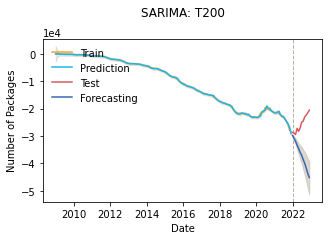

In [64]:
plot_predictions(train,test)
#forecast_200=forecast_series

In [65]:
#calculate evolation metrics
#k=model.order[0]+model.order[2]+model.seasonal_order[0]+model.seasonal_order[2]+train_exo_np.shape[1]
#print("Training Metrics: ", forecast_accuracy(train, train_predict, k))
#print("Testing Metrics: ", forecast_accuracy(test, forecast_series, k))

Train_RMSE,Train_SMAPE=forecast_accuracy(train, train_predict)
Test_RMSE,Test_SMAPE=forecast_accuracy(test, forecast_series)
print('Root Mean Squared Error(Train_RMSE): ', Train_RMSE)
print('Root Mean Squared Error(Test_RMSE) : ',  Test_RMSE)
print('Mean Absolute Percentage Error(Train_SMAPE): ', Train_SMAPE)
print('Mean Absolute Percentage Error(Test_SMAPE) : ', Test_SMAPE)

Root Mean Squared Error(Train_RMSE):  228.0
Root Mean Squared Error(Test_RMSE) :  13762.0
Mean Absolute Percentage Error(Train_SMAPE):  6.12
Mean Absolute Percentage Error(Test_SMAPE) :  35.63


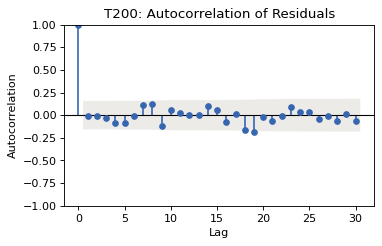

In [66]:
plot_residuals(model, train)

In [67]:
train=df100_train_date
test = df100_test_date
train_exo_np=np.empty((0, 0))
test_exo_np=np.empty((0, 0))

model = pm.auto_arima(train, X=None, 
                      start_p=0, d=None, start_q=0, 
                      max_p=5, max_d=3, max_q=5, 
                      start_P=0, D=None, start_Q=0, 
                      max_P=3, max_D=1, max_Q=3, 
                      max_order=3, m=12, seasonal=True, 
                      stationary=False, information_criterion='aic', 
                      alpha=0.05, test='adf', seasonal_test='ocsb', 
                      stepwise=False, n_jobs=1, start_params=None, 
                      method='lbfgs', maxiter=100, trend="n", #{‘n’,’c’,’t’,’ct’}
                      offset_test_args=None, seasonal_test_args=None, 
                      suppress_warnings=True, error_action='trace', 
                      trace=False, random=False, random_state=None, 
                      n_fits=10, return_valid_fits=False, out_of_sample_size=0, 
                      scoring='mse', scoring_args=None, with_intercept="auto", #"auto", True, False
                      sarimax_kwargs=None)


print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  156
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -1340.184
Date:                             Wed, 29 Nov 2023   AIC                           2688.367
Time:                                     17:50:42   BIC                           2700.541
Sample:                                 01-01-2009   HQIC                          2693.312
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2031      0.045     -4.550      0.000      -0.291      -0.116
ma.L2          0.3502      

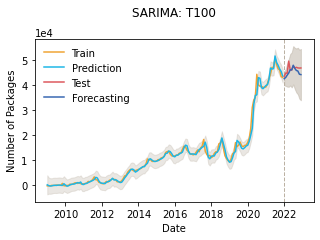

In [68]:
plot_predictions(train, test)
#forecast_100=forecast_series
#np.exp(train)

In [69]:
#calculate evolation metrics
#k=model.order[0]+model.order[2]+model.seasonal_order[0]+model.seasonal_order[2]+train_exo_np.shape[1]
#print("Training Metrics: ", forecast_accuracy(train, train_predict, k))
#print("Testing Metrics: ", forecast_accuracy(test, forecast_series, k))

Train_RMSE,Train_SMAPE=forecast_accuracy(train, train_predict)
Test_RMSE,Test_SMAPE=forecast_accuracy(test, forecast_series)
print('Root Mean Squared Error(Train_RMSE): ', Train_RMSE)
print('Root Mean Squared Error(Test_RMSE) : ',  Test_RMSE)
print('Mean Absolute Percentage Error(Train_SMAPE): ', Train_SMAPE)
print('Mean Absolute Percentage Error(Test_SMAPE) : ', Test_SMAPE)

Root Mean Squared Error(Train_RMSE):  1359.0
Root Mean Squared Error(Test_RMSE) :  1906.0
Mean Absolute Percentage Error(Train_SMAPE):  19.73
Mean Absolute Percentage Error(Test_SMAPE) :  3.0


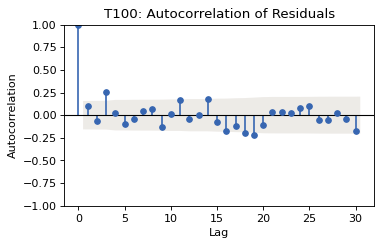

In [70]:
plot_residuals(model, train)

In [71]:

train = df50_train_date
test = df50_test_date
train_exo_np=np.empty((0, 0))
test_exo_np=np.empty((0, 0))

model = pm.auto_arima(train, X=None, 
                      start_p=0, d=None, start_q=0, 
                      max_p=5, max_d=3, max_q=5, 
                      start_P=1, D=1, start_Q=1, 
                      max_P=3, max_D=1, max_Q=3, 
                      max_order=2, m=12, seasonal=True, 
                      stationary=False, information_criterion='aic', 
                      alpha=0.05, test='adf', seasonal_test='ocsb', 
                      stepwise=False, n_jobs=1, start_params=None, 
                      method='lbfgs', maxiter=100, trend="n", #{‘n’,’c’,’t’,’ct’}
                      offset_test_args=None, seasonal_test_args=None, 
                      suppress_warnings=True, error_action='trace', 
                      trace=False, random=False, random_state=None, 
                      n_fits=10, return_valid_fits=False, out_of_sample_size=0, 
                      scoring='mse', scoring_args=None, with_intercept="auto", #"auto", True, False
                      sarimax_kwargs=None)
print(model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1130.697
Date:                              Wed, 29 Nov 2023   AIC                           2267.394
Time:                                      17:50:49   BIC                           2276.282
Sample:                                  01-01-2009   HQIC                          2271.005
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3051      0.049     -6.212      0.000      -0.401      -0.209
ma.S.L12      -0.68

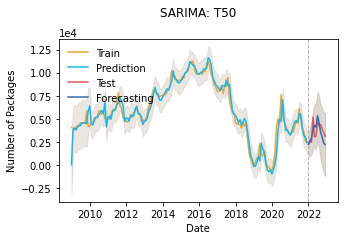

In [72]:
plot_predictions(train, test)
#forecast_50=forecast_series

In [73]:
#calculate evolation metrics
#k=model.order[0]+model.order[2]+model.seasonal_order[0]+model.seasonal_order[2]+train_exo_np.shape[1]
#print("Training Metrics: ", forecast_accuracy(train, train_predict, k))
#print("Testing Metrics: ", forecast_accuracy(test, forecast_series, k))

Train_RMSE,Train_SMAPE=forecast_accuracy(train, train_predict)
Test_RMSE,Test_SMAPE=forecast_accuracy(test, forecast_series)
print('Root Mean Squared Error(Train_RMSE): ', Train_RMSE)
print('Root Mean Squared Error(Test_RMSE) : ',  Test_RMSE)
print('Mean Absolute Percentage Error(Train_SMAPE): ', Train_SMAPE)
print('Mean Absolute Percentage Error(Test_SMAPE) : ', Test_SMAPE)

Root Mean Squared Error(Train_RMSE):  748.0
Root Mean Squared Error(Test_RMSE) :  862.0
Mean Absolute Percentage Error(Train_SMAPE):  19.13
Mean Absolute Percentage Error(Test_SMAPE) :  21.49


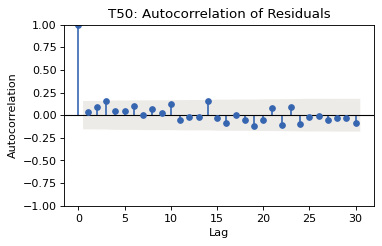

In [74]:
plot_residuals(model, train)

In [75]:
train = df20_train_date
test = df20_test_date
train_exo_np=np.empty((0, 0))
test_exo_np=np.empty((0, 0))

model = pm.auto_arima(train, X=None, 
                      start_p=0, d=None, start_q=0, 
                      max_p=5, max_d=3, max_q=5, 
                      start_P=1, D=1, start_Q=1, 
                      max_P=3, max_D=1, max_Q=3, 
                      max_order=2, m=12, seasonal=True, 
                      stationary=False, information_criterion='aic', 
                      alpha=0.05, test='adf', seasonal_test='ocsb', 
                      stepwise=False, n_jobs=1, start_params=None, 
                      method='lbfgs', maxiter=100, trend="n", #{‘n’,’c’,’t’,’ct’}
                      offset_test_args=None, seasonal_test_args=None, 
                      suppress_warnings=True, error_action='trace', 
                      trace=False, random=False, random_state=None, 
                      n_fits=10, return_valid_fits=False, out_of_sample_size=0, 
                      scoring='mse', scoring_args=None, with_intercept="auto", #"auto", True, False
                      sarimax_kwargs=None)
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1039.218
Date:                              Wed, 29 Nov 2023   AIC                           2084.435
Time:                                      17:50:56   BIC                           2093.324
Sample:                                  01-01-2009   HQIC                          2088.047
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3250      0.058     -5.633      0.000      -0.438      -0.212
ma.S.L12      -0.31

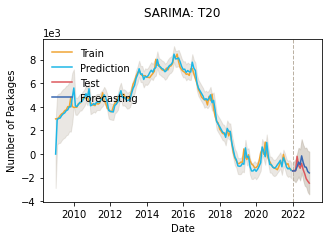

In [76]:
plot_predictions(train, test)
#forecast_20=forecast_series

In [77]:
#calculate evolation metrics
#k=model.order[0]+model.order[2]+model.seasonal_order[0]+model.seasonal_order[2]+train_exo_np.shape[1]
#print("Training Metrics: ", forecast_accuracy(train, train_predict, k))
#print("Testing Metrics: ", forecast_accuracy(test, forecast_series, k))

Train_RMSE,Train_SMAPE=forecast_accuracy(train, train_predict)
Test_RMSE,Test_SMAPE=forecast_accuracy(test, forecast_series)
print('Root Mean Squared Error(Train_RMSE): ', Train_RMSE)
print('Root Mean Squared Error(Test_RMSE) : ',  Test_RMSE)
print('Mean Absolute Percentage Error(Train_SMAPE): ', Train_SMAPE)
print('Mean Absolute Percentage Error(Test_SMAPE) : ', Test_SMAPE)

Root Mean Squared Error(Train_RMSE):  440.0
Root Mean Squared Error(Test_RMSE) :  606.0
Mean Absolute Percentage Error(Train_SMAPE):  20.3
Mean Absolute Percentage Error(Test_SMAPE) :  49.43


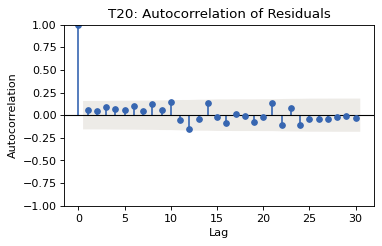

In [78]:
plot_residuals(model, train)

In [79]:
train = df10_train_date
test = df10_test_date
train_exo_np=np.empty((0, 0))
test_exo_np=np.empty((0, 0))

model = pm.auto_arima(train, X=None, 
                      start_p=0, d=1, start_q=0, 
                      max_p=5, max_d=3, max_q=5, 
                      start_P=1, D=None, start_Q=1, 
                      max_P=3, max_D=1, max_Q=3, 
                      max_order=2, m=12, seasonal=True, 
                      stationary=False, information_criterion='aic', 
                      alpha=0.05, test='adf', seasonal_test='ocsb', 
                      stepwise=False, n_jobs=1, start_params=None, 
                      method='lbfgs', maxiter=100, trend="n", #{‘n’,’c’,’t’,’ct’}
                      offset_test_args=None, seasonal_test_args=None, 
                      suppress_warnings=True, error_action='trace', 
                      trace=False, random=False, random_state=None, 
                      n_fits=10, return_valid_fits=False, out_of_sample_size=0, 
                      scoring='mse', scoring_args=None, with_intercept="auto", #"auto", True, False
                      sarimax_kwargs=None)
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1097.936
Date:                            Wed, 29 Nov 2023   AIC                           2201.872
Time:                                    17:51:01   BIC                           2211.003
Sample:                                01-01-2009   HQIC                          2205.581
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3448      0.050     -6.865      0.000      -0.443      -0.246
ar.S.L12       0.6041      0.052   

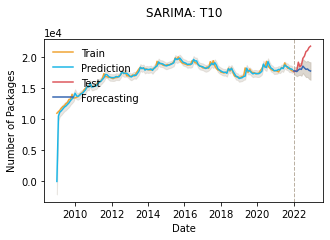

In [80]:
plot_predictions(train, test)
#forecast_10=forecast_series

In [81]:
#calculate evolation metrics
#k=model.order[0]+model.order[2]+model.seasonal_order[0]+model.seasonal_order[2]+train_exo_np.shape[1]
#print("Training Metrics: ", forecast_accuracy(train, train_predict, k))
#print("Testing Metrics: ", forecast_accuracy(test, forecast_series, k))

Train_RMSE,Train_SMAPE=forecast_accuracy(train, train_predict)
Test_RMSE,Test_SMAPE=forecast_accuracy(test, forecast_series)
print('Root Mean Squared Error(Train_RMSE): ', Train_RMSE)
print('Root Mean Squared Error(Test_RMSE) : ',  Test_RMSE)
print('Mean Absolute Percentage Error(Train_SMAPE): ', Train_SMAPE)
print('Mean Absolute Percentage Error(Test_SMAPE) : ', Test_SMAPE)

Root Mean Squared Error(Train_RMSE):  927.0
Root Mean Squared Error(Test_RMSE) :  2123.0
Mean Absolute Percentage Error(Train_SMAPE):  2.55
Mean Absolute Percentage Error(Test_SMAPE) :  8.26


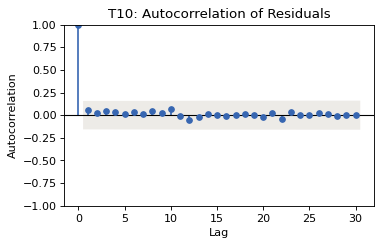

In [82]:
plot_residuals(model, train)

In [83]:
train = df5_train_date
test = df5_test_date
train_exo_np=np.empty((0, 0))
test_exo_np=np.empty((0, 0))

model = pm.auto_arima(train, X=None, 
                      start_p=0, d=2, start_q=0, 
                      max_p=5, max_d=3, max_q=5, 
                      start_P=0, D=1, start_Q=1, 
                      max_P=0, max_D=1, max_Q=1, 
                      max_order=3, m=12, seasonal=True, 
                      stationary=False, information_criterion='aic', 
                      alpha=0.05, test='adf', seasonal_test='ocsb', 
                      stepwise=False, n_jobs=1, start_params=None, 
                      method='lbfgs', maxiter=100, trend="n", #{‘n’,’c’,’t’,’ct’}
                      offset_test_args=None, seasonal_test_args=None, 
                      suppress_warnings=True, error_action='trace', 
                      trace=False, random=False, random_state=None, 
                      n_fits=10, return_valid_fits=False, out_of_sample_size=0, 
                      scoring='mse', scoring_args=None, with_intercept="auto", #"auto", True, False
                      sarimax_kwargs=None)
print(model.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(3, 2, 0)x(0, 1, 0, 12)   Log Likelihood               -1041.533
Date:                            Wed, 29 Nov 2023   AIC                           2091.065
Time:                                    17:51:08   BIC                           2102.889
Sample:                                01-01-2009   HQIC                          2095.870
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1938      0.055    -21.793      0.000      -1.301      -1.086
ar.L2         -0.8194      0.089   

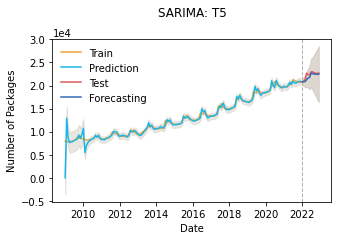

In [84]:
plot_predictions(train, test)
#forecast_5=forecast_series

In [85]:
#calculate evolation metrics
#k=model.order[0]+model.order[2]+model.seasonal_order[0]+model.seasonal_order[2]+train_exo_np.shape[1]
#print("Training Metrics: ", forecast_accuracy(train, train_predict, k))
#print("Testing Metrics: ", forecast_accuracy(test, forecast_series, k))

Train_RMSE,Train_SMAPE=forecast_accuracy(train, train_predict)
Test_RMSE,Test_SMAPE=forecast_accuracy(test, forecast_series)
print('Root Mean Squared Error(Train_RMSE): ', Train_RMSE)
print('Root Mean Squared Error(Test_RMSE) : ',  Test_RMSE)
print('Mean Absolute Percentage Error(Train_SMAPE): ', Train_SMAPE)
print('Mean Absolute Percentage Error(Test_SMAPE) : ', Test_SMAPE)

Root Mean Squared Error(Train_RMSE):  892.0
Root Mean Squared Error(Test_RMSE) :  530.0
Mean Absolute Percentage Error(Train_SMAPE):  4.11
Mean Absolute Percentage Error(Test_SMAPE) :  1.78


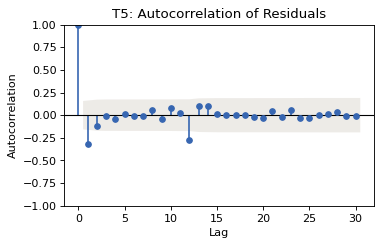

In [86]:
plot_residuals(model, train)